In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import pandas as pd

In [5]:
df = pd.read_csv("/kaggle/input/news-category-under-sampled/cat_cleaned.csv")

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('distilbert/distilgpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {"BUSINESS": 0, "ENTERTAINMENT" : 1, "SPORTS" : 2, "OTHER" : 3}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['labels']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=512,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [7]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

20602 2575 2576


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [3]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [7]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
        torch.save(model.state_dict(), f"gpt2-text-classifier-model-E{epoch_num}.pt")
            
EPOCHS = 3
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=4, max_seq_len=512, gpt_model_name='distilbert/distilgpt2')
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)
torch.save(model.state_dict(), "gpt2-text-classifier-model-E4.pt")

100%|██████████| 10301/10301 [13:10<00:00, 13.02it/s]


Epochs: 1 | Train Loss:  0.227             | Train Accuracy:  0.846             | Val Loss:  0.175             | Val Accuracy:  0.875


100%|██████████| 10301/10301 [13:10<00:00, 13.03it/s]


Epochs: 2 | Train Loss:  0.113             | Train Accuracy:  0.922             | Val Loss:  0.170             | Val Accuracy:  0.886


100%|██████████| 10301/10301 [13:11<00:00, 13.02it/s]


Epochs: 3 | Train Loss:  0.038             | Train Accuracy:  0.974             | Val Loss:  0.225             | Val Accuracy:  0.899


In [ ]:
torch.save(model.state_dict(), "gpt2-text-classifier-model-E4.pt")

In [10]:
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=4, max_seq_len=512, gpt_model_name="distilbert/distilgpt2")
model_new.load_state_dict(torch.load("/kaggle/working/gpt2-text-classifier-model-E2.pt"))
#model_new.eval()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

<All keys matched successfully>

In [25]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    


In [26]:
true_labels, pred_labels = evaluate(model_new, df_test)

Test Accuracy:  0.893


In [27]:
print(classification_report(true_labels, pred_labels, labels=range(len(labels))))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       689
           1       0.88      0.95      0.91       686
           2       0.95      0.96      0.95       596
           3       0.85      0.77      0.81       605

    accuracy                           0.89      2576
   macro avg       0.89      0.89      0.89      2576
weighted avg       0.89      0.89      0.89      2576



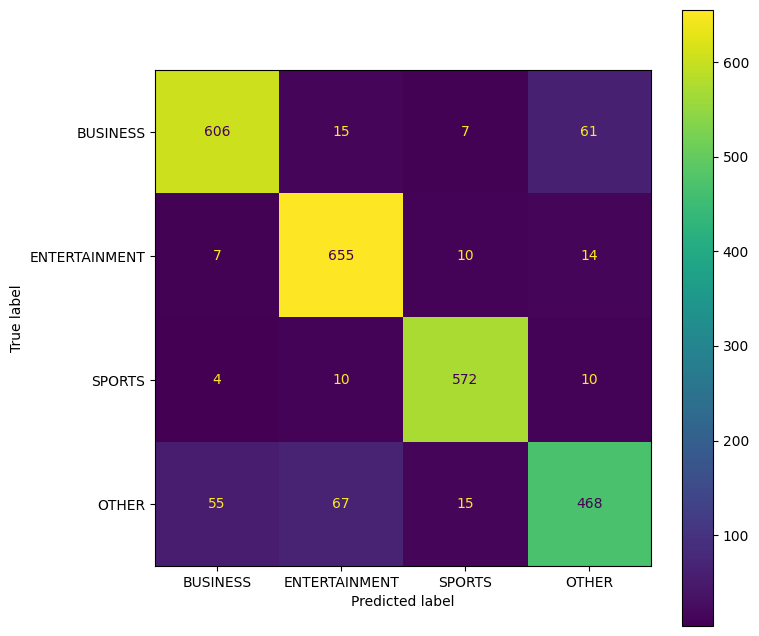

In [28]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

In [29]:
model_base = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=4, max_seq_len=512, gpt_model_name="distilbert/distilgpt2")

In [30]:
true_labels, pred_labels = evaluate(model_base, df_test)

Test Accuracy:  0.236


In [31]:
print(classification_report(true_labels, pred_labels, labels=range(len(labels))))

              precision    recall  f1-score   support

           0       0.16      0.06      0.09       689
           1       0.38      0.20      0.26       686
           2       0.22      0.71      0.33       596
           3       0.67      0.00      0.01       605

    accuracy                           0.24      2576
   macro avg       0.36      0.24      0.17      2576
weighted avg       0.35      0.24      0.17      2576



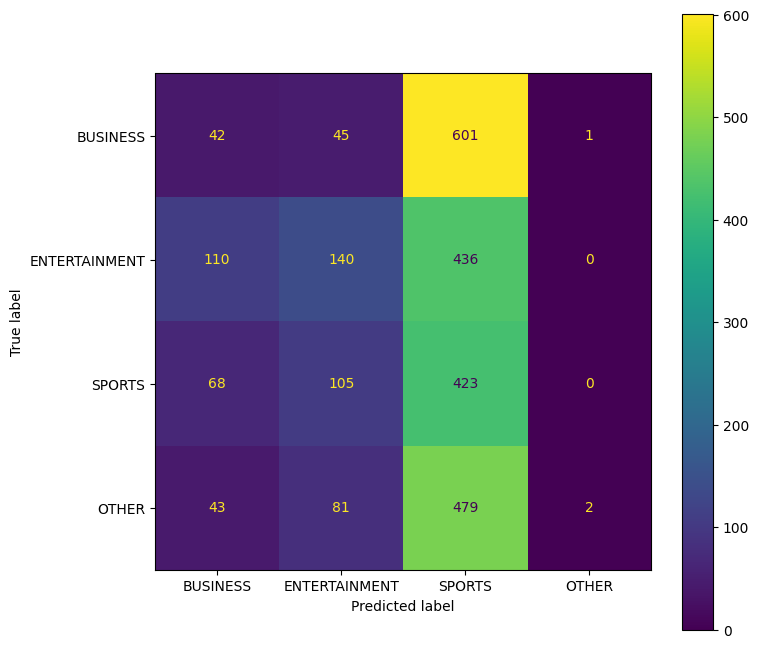

In [32]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)